# Generation and analysis of Ligand-Protein IFPs for RAMD simulations (dcd trajectories)

    1. Computing interaction fingerprints (IFP) for 
        system equilibration trajectory 
        ligand dissociation trajectories
    2.  Visualizion of 
        protein residues that are involved in protein-ligand interactions, including water-bridges
        ligand dissociation   


### Author: Daria Kokh
    v.1.0
    Copyright (c) 2019
    Released under the GNU Public Licence, v2 or any higher version
    


### Input data required:
    - trajectory file 
    - pdb file (for example, generated from the first frame)
    - ligand mole2 and pdb files
    
    All examples are  provided in the Data directory:
        - Data/2YKI  - an example of the  analysis of a single PDB file 
        - Data/6EI5/ - an example of the analysis of a single trajectory
        - Data/4MQT/ORTO-CHL-lipid14/ - an example of the analysis of several trajectories obtained from RAMD simulations
    
### Packages required:
    numpy
    pandas
    matplotlib
    MDAnalysis
    RDkit
    scipy
    code is written on Python 3.x and tested on Python 3.7




#  Application example: GPCR embedded in a membrane

    GPCR - Muscarinic Receptor M2 in a membrane
    Membrane containing cholesterol 50%  + POPC + POPE and M2 muscarinic receptor (PDB ID=4MQT)

Before we start, let us import the required scripts and packages.

In [1]:
import MDAnalysis as mda
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from rdkit import Chem

##  1. Computation of PL IFPs  for a single dcd trajectory

    Generation of PL IFP  for a membrane protein bound to a ligand (muscarinic receptor M2; PDB:4MQT)
    
    Data used:
    PDB file of a complete system equilibrated using AMBER
    MD trajectory in DCD format (generated using NAMD software)
    ligand PDB and Mol2 files 
    (Important: not all Mol2 formats can be read by RDKit, file generated by MOE software works well)
    
    Result:
    A dataframe (df_prop_complet) will be generated; it contains PL IFP for each frame analyzed


### 1.1 Data preparation and ligand analysis

In [2]:
# Define the path to our input data
ref =  "Data/4MQT/ORTO-CHL-lipid14/AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
traj = "Data/4MQT/ORTO-CHL-lipid14/RAMD/Replica1/Traj1/ORTO-CHL_108_ramd_016.dcd"
ligand_pdb = "Data/4MQT/ORTO-CHL-lipid14/IXO.pdb"
ligand_mol2 = "Data/4MQT/ORTO-CHL-lipid14/moe.mol2"

# Define the part of the trajectory we will analize
start = 200
stop = -1
step = 10

# Load the trajectory into an MDAnalysis universe
u = mda.Universe(ref,traj)
print("the total length of trajectory: ",len(u.trajectory)," frames")

# Define the identifier of the ligand we want to analize
sel_ligands = " IXO "

# Define a sub-system we wish to analize (we are going to exclude membrane residues now for faster compution)
u_reduced = u.select_atoms(" protein or (resname WAT "+sel_ligands+")")

# Load part of the trajectory into memory
u_mem = mda.Merge(u_reduced).load_new(AnalysisFromFunction(
                    lambda ag: ag.positions.copy(), u_reduced).run(
                        start=start,stop=stop,step=step).results,format=MemoryReader)
print('Will be analized: ', len(u_mem.trajectory), 'frames')

the total length of trajectory:  721  frames
Will be analized:  52 frames


Now we need to obtain the chemical properties of the ligand. For this we provide two options. Which one to use is down to personal preference, functional might be more intuitive for unexperienced programmers, while using the class based way has some additional functionality.  
Details about the definition of the properties can be found at https://github.com/rdkit/rdkit/blob/master/Data/BaseFeatures.fdef. 
  
Functional:

In [3]:
properties, mol = ligand_properties(ligand_pdb, ligand_mol2)
print('Ligand properties:' ,properties)

Ligand properties: {'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}


Object oriented (considers a few additional interactions, e.g. F3 as hydrophobic):

In [4]:
my_ligand = Ligand("./",ligand_pdb,ligand_mol2)
properties = my_ligand.property_list
print("Ligand properties: ",properties)

Ligand properties:
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
Ligand properties:  {'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}


### 1.2 Generate and visualize PL IFPs

Start HB analysis 12:21:24.191572
Start WB analysis 12:21:29.210431
Start collecting IFPs:  12:22:37.452565
Start building IFP table:  12:26:08.547452
IFP database is ready  12:26:08.585163


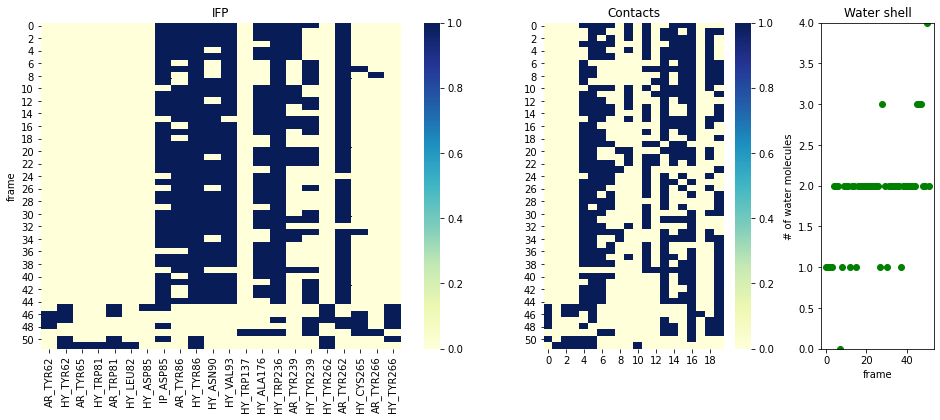

In [5]:
# Compute the IFP
df_prop,df_HB,df_WB = IFP(u_mem, sel_ligands, properties, WB_analysis=True, RE=True, Lipids= [])

# Merge the data into one dataframe
df_prop_complete = table_combine(df_HB, df_WB, df_prop, sel_ligands)

# Plot the finished table
Plot_IFP(df_prop_complete)

## 2. Generation of IFP dataframe with a trajectory object

In addition to the functions presented in 1.2 , we offer the option of performing all of the above in the scope of the trajectories class.  
Note that we start analyzing only after the last 200/300 frames and the ligand is moving out of the binding pocket, which is the reason for the large RMSD.

### 2.1 Instantiate a trajectory object

In [4]:
# Define the path to the stored data
DIR_all = "Data/4MQT/ORTO-CHL-lipid14/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica*"
ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligand_pdb = "IXO.pdb"
ligand_mol2 = "moe.mol2"

# Instantiate the trajectorie object with the paths/ filenames for the data
tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd, ligand_pdb=ligand_pdb,
                  ligand_mol2=ligand_mol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref_pdb, timestep = 1)

Ligand properties:
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
ligand name:       IXO
2  Equilibration trajectories found
2  RAMD traj. found in  Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica1
2  RAMD traj. found in  Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica2


### 2.2 Computation of PL IFPs for all equilibration trajectories

For the following diagram line 0-3 represent RMSD addition selections, usually several residues provided as input for the trajectory analysis. 



>>>>>>>>>>>>>>>>> Replica:  Data/4MQT/ORTO-CHL-lipid14//NAMD_eq\Replica1\ORT-CHL_repl.dcd 

total number of frames= 1418; file size 1934 M
>>>???  protein or (resname WAT HOH SOL IXO) or ((resid 8:21) and (not type H)) or ((resid 48:65) and (not type H)) or ((resid 88:91) and (not type H)) or ((resid 151:157) and (not type H))
will be analyzed  30 frames
traj# 0 RMSD protein:  1.3730883418270268 RMSD ligand:  0.9872856069944753 ligand residue name IXO
Start HB analysis 12:27:07.310478
Start WB analysis 12:27:09.892202
Start collecting IFPs:  12:28:19.387934
Start building IFP table:  12:30:15.592948
IFP database is ready  12:30:15.611322


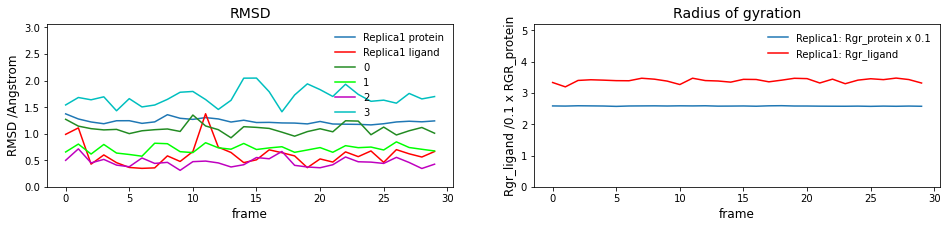



>>>>>>>>>>>>>>>>> Replica:  Data/4MQT/ORTO-CHL-lipid14//NAMD_eq\Replica2\ORT-CHL_repl.dcd 

total number of frames= 1153; file size 1572 M
>>>???  protein or (resname WAT HOH SOL IXO) or ((resid 8:21) and (not type H)) or ((resid 48:65) and (not type H)) or ((resid 88:91) and (not type H)) or ((resid 151:157) and (not type H))
will be analyzed  30 frames
for the frame 0 protein RMSD is very large: 33.78146117915253
for the frame 0 ligand RMSD is very large: 21.612205965745854
traj# 0 RMSD protein:  33.78146117915253 RMSD ligand:  21.612205965745854 ligand residue name IXO
for the frame 1 protein RMSD is very large: 33.71937138110584
for the frame 1 ligand RMSD is very large: 21.641979223195218
for the frame 2 protein RMSD is very large: 33.73659414217617
for the frame 2 ligand RMSD is very large: 21.568723065540613
for the frame 3 protein RMSD is very large: 33.763777725367106
for the frame 3 ligand RMSD is very large: 21.703061015432183
for the frame 4 protein RMSD is very large: 33

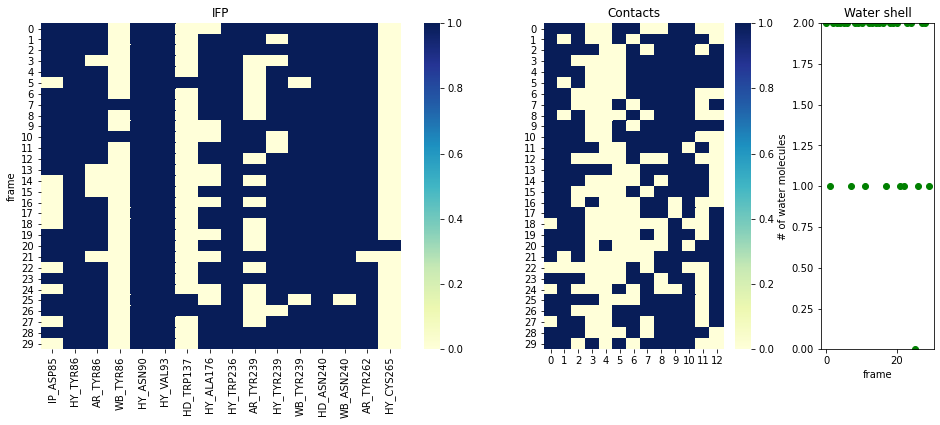

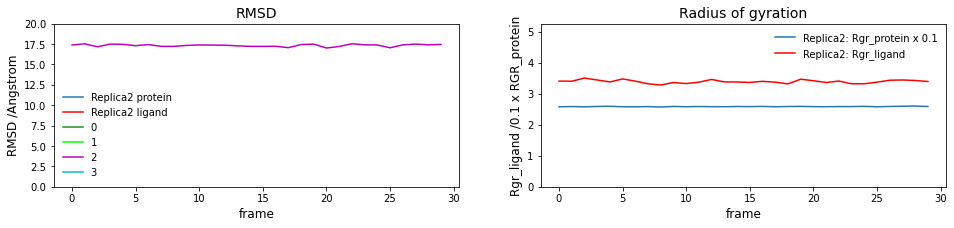

0 Replica1
1 Replica2


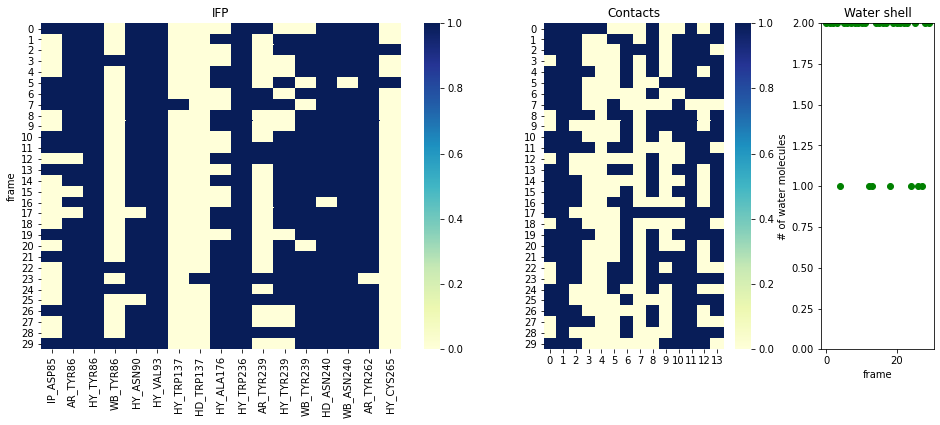

In [7]:
auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 88:91) and (not type H))","((resid 151:157) and (not type H))"]
name = 'ORTO-CHL-lipid14'

# We start the analysis of the namd data and define ...
tr.analysis_all_namd(WB_analysis = True, Lipids = [],auxi_selection = auxi_selection,step_analysis=step, start_analysis=-300)

# Safe the IFP dataframe to the specified location
IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+name+"_NAMD_com.pkl")

### 2.3 Computation of PL IFPs for all dissociation trajectories  
Note that at least 10 trajectories should be simulated for tau calculation. If less are supplied tau will not be calculated. 

!!!! RAMD trajectory set for Replica1 is too small (2 traj.), tau will not be computed for this replica 
!!!! RAMD trajectory set for Replica2 is too small (2 traj.), tau will not be computed for this replica 


>>>>>>>>>>>>>>>>> Replica  0 :  Replica1 

>>>>>>>>>= 0 Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica1\Traj1\ORTO-CHL_108_ramd_016.dcd
total number of frames= 721; file size 983 M
>>>???  protein or (resname WAT HOH SOL IXO)
will be analyzed  100 frames
traj# 0 RMSD protein:  1.7838144208108764 RMSD ligand:  1.4915350354057166 ligand residue name IXO
for the frame 92 ligand RMSD is very large: 10.060345408600618
for the frame 93 ligand RMSD is very large: 11.29884853884316
for the frame 94 ligand RMSD is very large: 11.082218769004662
for the frame 95 ligand RMSD is very large: 11.989889151411315
for the frame 96 ligand RMSD is very large: 13.664263392288248
for the frame 97 ligand RMSD is very large: 15.244168342244368
for the frame 98 ligand RMSD is very large: 19.356064230750945


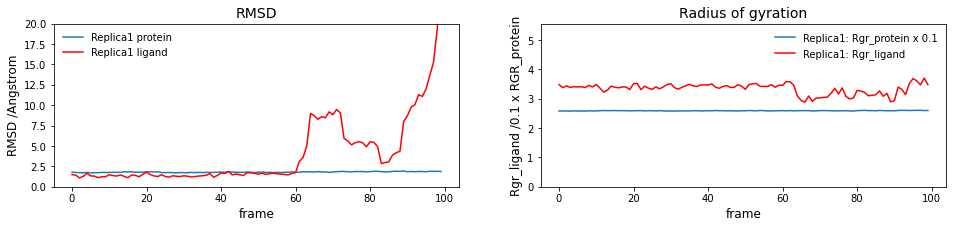

>>>>>>>>>= 1 Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica1\Traj2\ORTO-CHL_104_ramd_016.dcd
total number of frames= 452; file size 616 M
>>>???  protein or (resname WAT HOH SOL IXO)
will be analyzed  100 frames
traj# 0 RMSD protein:  1.776475751018144 RMSD ligand:  1.308791183360776 ligand residue name IXO
for the frame 94 ligand RMSD is very large: 10.504850361395674
for the frame 95 ligand RMSD is very large: 11.153463897281531
for the frame 96 ligand RMSD is very large: 11.285078970300532
for the frame 97 ligand RMSD is very large: 14.6125950120132
for the frame 98 ligand RMSD is very large: 19.2708384756754
for the frame 99 ligand RMSD is very large: 27.7203055930756
Start HB analysis 12:52:47.320139
Start WB analysis 12:52:55.295189
Start collecting IFPs:  12:57:18.433714
Start building IFP table:  13:03:47.147202
IFP database is ready  13:03:47.201588


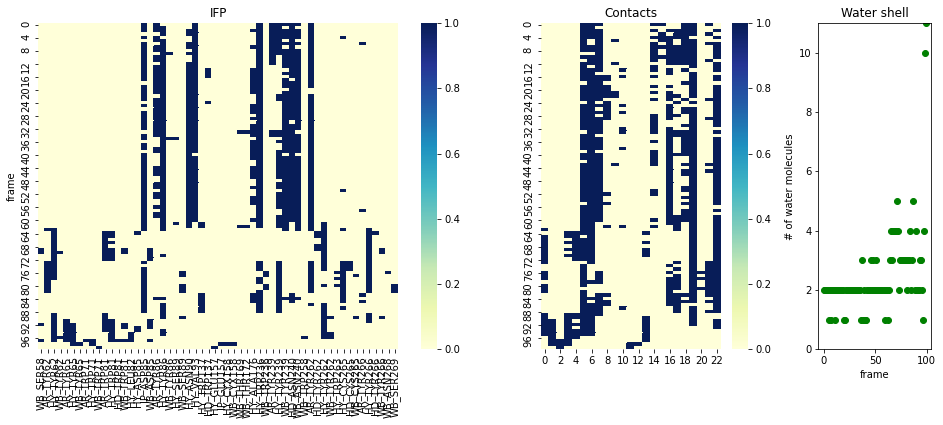

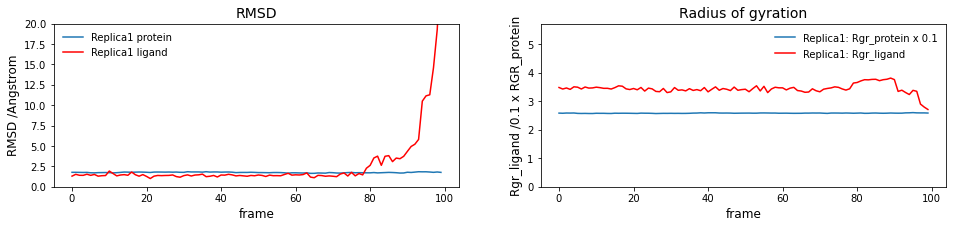



>>>>>>>>>>>>>>>>> Replica  1 :  Replica2 

>>>>>>>>>= 0 Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica2\Traj1\ORTO-CHL_111_ramd_016.dcd
total number of frames= 144; file size 196 M
>>>???  protein or (resname WAT HOH SOL IXO)
will be analyzed  72 frames
traj# 0 RMSD protein:  1.9823081670192846 RMSD ligand:  1.5620144333655006 ligand residue name IXO
for the frame 69 ligand RMSD is very large: 11.544952944584374
for the frame 70 ligand RMSD is very large: 19.587828956982612
for the frame 71 ligand RMSD is very large: 27.536835516142695
Start HB analysis 13:05:38.698640
Start WB analysis 13:05:44.497141
Start collecting IFPs:  13:09:00.716191
Start building IFP table:  13:13:35.858693
IFP database is ready  13:13:35.896591


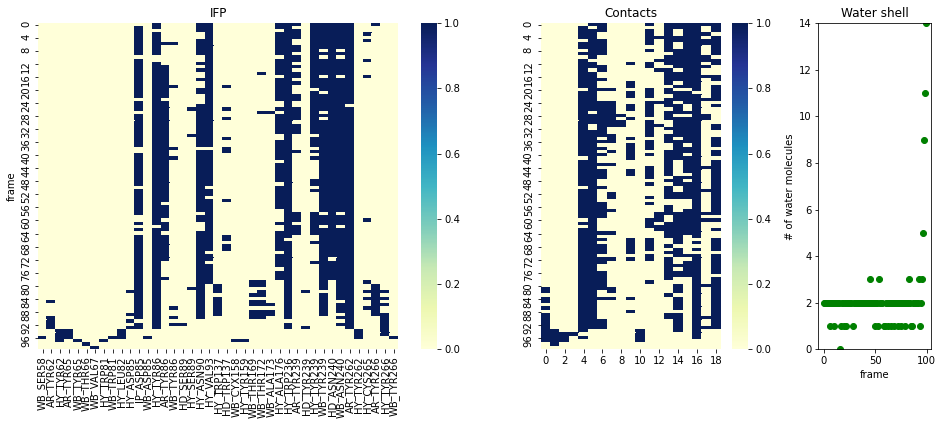

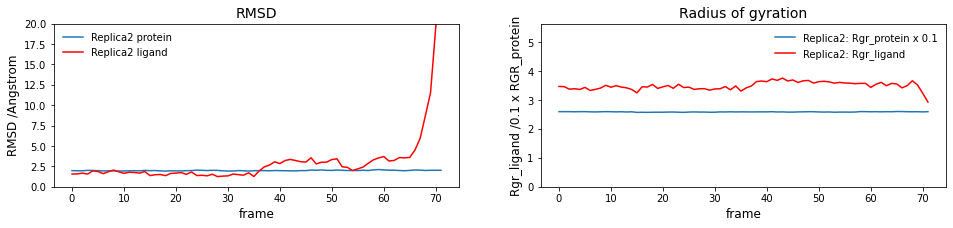

>>>>>>>>>= 1 Data/4MQT/ORTO-CHL-lipid14//RAMD\Replica2\Traj2\ORTO-CHL_105_ramd_016.dcd
total number of frames= 405; file size 552 M
>>>???  protein or (resname WAT HOH SOL IXO)
will be analyzed  100 frames
traj# 0 RMSD protein:  1.8737354623165585 RMSD ligand:  1.38196250484051 ligand residue name IXO
for the frame 75 ligand RMSD is very large: 10.866057163141951
for the frame 76 ligand RMSD is very large: 12.089188053984627
for the frame 77 ligand RMSD is very large: 14.047216349166417
for the frame 78 ligand RMSD is very large: 15.100338030102748
for the frame 79 ligand RMSD is very large: 15.289352515381978
for the frame 80 ligand RMSD is very large: 15.43331081969671
for the frame 81 ligand RMSD is very large: 15.302516647481482
for the frame 82 ligand RMSD is very large: 15.400237057347208
for the frame 83 ligand RMSD is very large: 15.465616885092096
for the frame 84 ligand RMSD is very large: 15.93864083783456
for the frame 85 ligand RMSD is very large: 15.847314705523784
for th

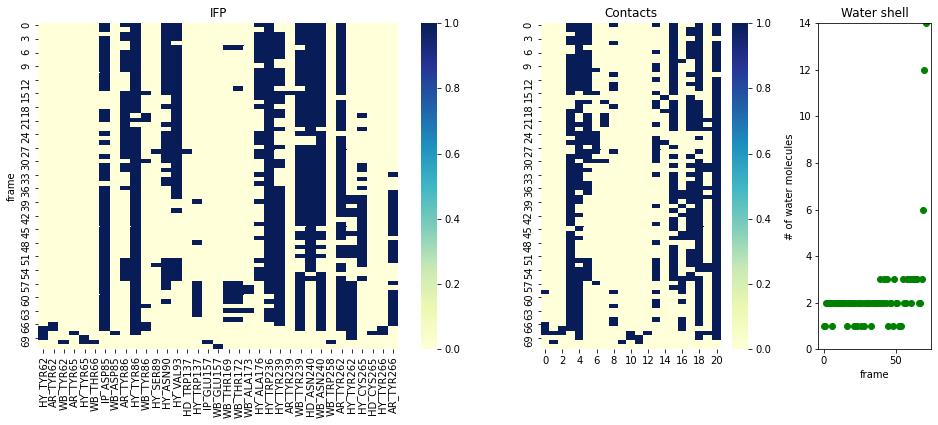

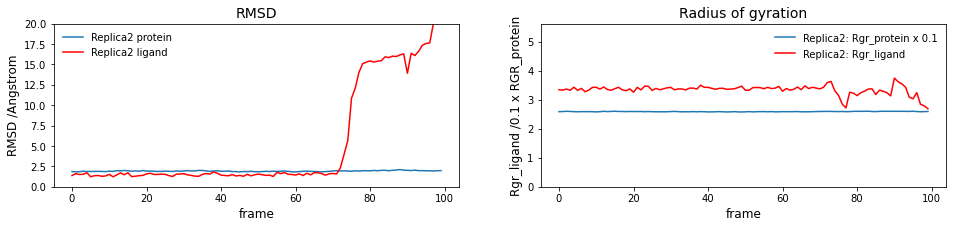

++++Will be saved+++++ ['Replica1', 'Replica2']


,time,WB_SER58,AR_TYR62,RE_TYR62,HY_TYR62,WB_TYR62,AR_TYR65,RE_TYR65,HY_TYR65,WB_TYR65,...,WB_THR66,WB_VAL67,WAT,Repl,Traj,RMSDl,RMSDp,RGyr,length,COM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.491535,1.783814,3.486786,721,"[48.05, 47.18, 60.57]"
1,1,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.435618,1.762618,3.376543,721,"[48.12, 47.03, 60.28]"
2,2,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.085493,1.734501,3.440529,721,"[47.62, 47.14, 60.22]"
3,3,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.282408,1.719048,3.385159,721,"[47.99, 46.84, 60.47]"
4,4,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.653717,1.758258,3.411072,721,"[48.13, 46.96, 60.64]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,17.575248,1.969224,3.031356,405,"[60.43, 45.01, 48.97]"
96,96,0,0,0,0,0,0,0,0,0,...,0,0,3,Replica2,1,17.652291,1.964150,3.244653,405,"[61.05, 45.15, 49.58]"
97,97,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,20.099481,1.936687,2.843083,405,"[63.36, 45.32, 48.5]"
98,98,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,21.420858,1.970441,2.791120,405,"[64.69, 45.55, 48.09]"


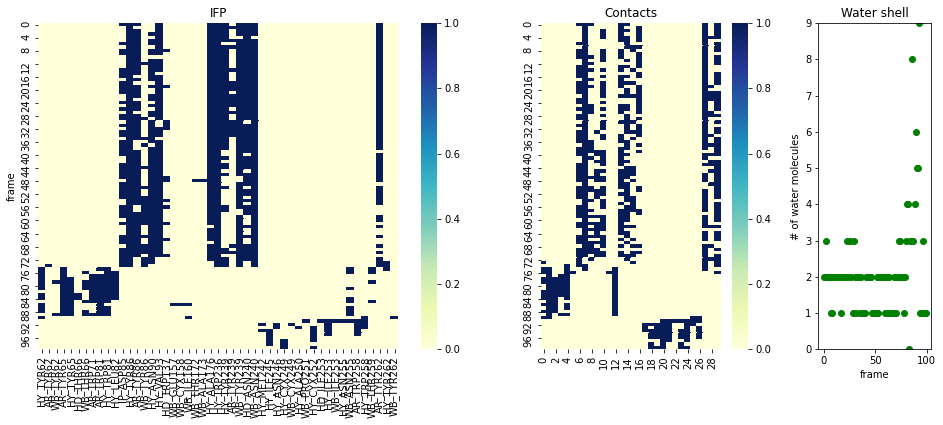

In [8]:
# Read the RAMD trajectories
tr.ramd.scan_ramd()

# Compute the IFPs for the RAMD dissociation trajectories
tr.analysis_all_ramd(WB_analysis = True, step_analysis=2, start_analysis=-200)

# Safe the IFP dataframe to the specified location
tr.ramd.IFP_save(tr.PRJ_DIR+name+"_RAMD_com.pkl")

### 2.4 Loading the generated IFP table and plotting it

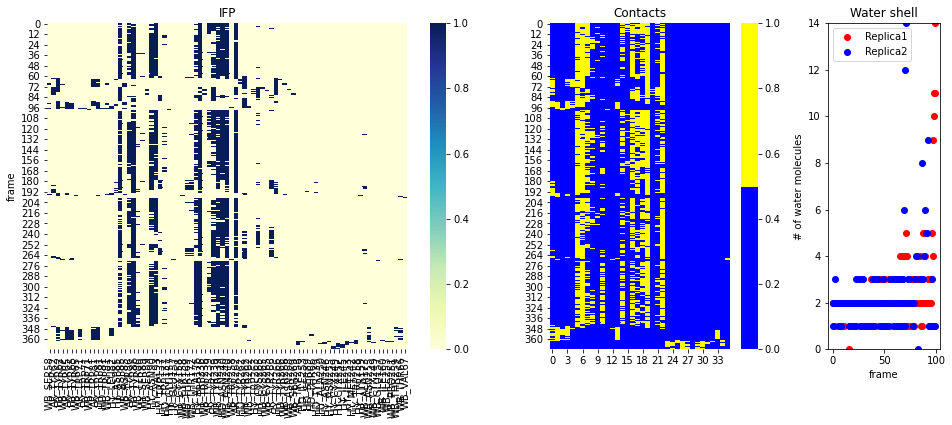

In [5]:
Plot_IFP(pd.read_pickle(tr.PRJ_DIR+"ORTO-CHL-lipid14_RAMD_com.pkl"))

### Explanation for the plots:  
The first plot shows the devlopment of detected IFPs over the time of the trajetorie.  
The second plot shows all contacts between ligand and protein over the time of the trajectorie.  
The third plot shows the amount of molecules participating in the water shell of the ligand.